# Week 12

Tensors and Neural Networks

In [ ]:
!wget -q https://github.com/PSAM-5020-2025F-A/5020-utils/raw/main/src/data_utils.py

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from torch import nn, Tensor
from torch.optim import Adagrad, Adam, SGD

from data_utils import object_from_json_url, regression_error

# House Price Regression

Let's load the housing prices dataset from `HW03`.

As always, we'll encode and scale our data if needed, and then we'll use the `train_test_split()` function to split our `DataFrame` into $2$ separate datasets, a training dataset with $80\%$ of the rows, and a test dataset with $20\%$.

In [ ]:
# Load Data
HOUSES_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025F-A/5020-utils/main/datasets/json/LA_housing.json"
houses_info = object_from_json_url(HOUSES_FILE)

# DataFrame it
houses_raw_df = pd.DataFrame.from_records(houses_info)

# Scale it
# Note: (technically we should split, then scale, but this saves a few lines of code)
house_scaler = StandardScaler().set_output(transform="pandas")
houses_df = house_scaler.fit_transform(houses_raw_df)

# Keep original outcome variable values
houses_df["value"] = houses_raw_df["value"]

# Train/Test split
houses_train_df, houses_test_df = train_test_split(houses_df, test_size=0.2, random_state=1010)

houses_train_df

## Classic Linear Regression

Let's set up a `LinearRegression()` model to predict house prices.

train error 906457.3460549254
test error 913542.343218954


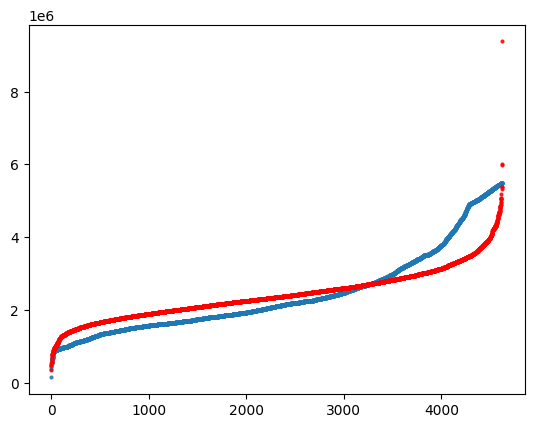

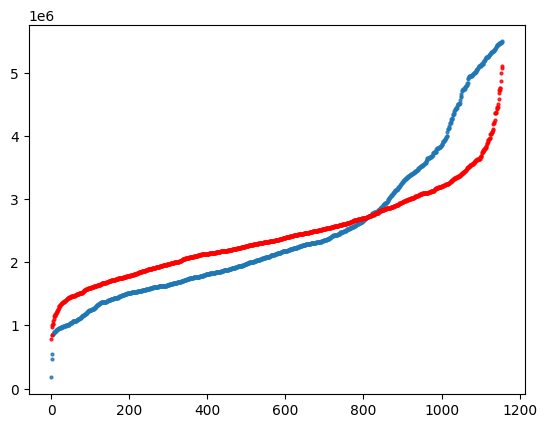

In [6]:
train_feat = houses_train_df.drop(columns=["value"])
train_out = houses_train_df["value"]

test_feat = houses_test_df.drop(columns=["value"])
test_out = houses_test_df["value"]

model = LinearRegression().fit(train_feat, train_out)

train_pred = model.predict(train_feat)
test_pred = model.predict(test_feat)

print("train error", regression_error(train_out, train_pred))
print("test error", regression_error(test_out, test_pred))

plt.plot(sorted(train_out), linestyle="", marker="o", markersize=2, alpha=0.8)
plt.plot(sorted(train_pred), linestyle="", marker="o", markersize=2, alpha=0.8, color="red")
plt.show()

plt.plot(sorted(test_out), linestyle="", marker="o", markersize=2, alpha=0.8)
plt.plot(sorted(test_pred), linestyle="", marker="o", markersize=2, alpha=0.8, color="red")
plt.show()

### Results

The model is off by almost a million dollars on average. We can add `PolynomialFeatures` to see how much more we can improve it.

In [7]:
# TODO: Add Polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False).set_output(transform="pandas")
train_feat_poly = poly.fit_transform(train_feat)

model = LinearRegression().fit(train_feat_poly, train_out)

train_pred = model.predict(train_feat_poly)
test_pred = model.predict(test_feat)

print("train error", regression_error(train_out, train_pred))
print("test error", regression_error(test_out, test_pred))

plt.plot(sorted(train_out), linestyle="", marker="o", markersize=2, alpha=0.8)
plt.plot(sorted(train_pred), linestyle="", marker="o", markersize=2, alpha=0.8, color="red")
plt.show()

plt.plot(sorted(test_out), linestyle="", marker="o", markersize=2, alpha=0.8)
plt.plot(sorted(test_pred), linestyle="", marker="o", markersize=2, alpha=0.8, color="red")
plt.show()


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- age bedrooms
- age bedrooms^2
- age rooms
- age rooms bedrooms
- age rooms^2
- ...


## Neural Network Linear Regression

Just like with the `LinearRegression` model, we have to separate our independent features and our outcome feature.

But, before we can put them through a neural network, we have to wrap them into `Tensor` objects.

The `Tensor` objects are fancy lists that have some of the same functionality as our `DataFrames`, but have been optimized for neural network operations.

We'll start by using the $5$ original features from our dataset, without any `PolynomialFeatures`.

In [15]:
train_feat

,longitude,latitude,age,rooms,bedrooms
5409,-1.395497,0.354259,-0.334464,-0.728600,0.295258
76,2.093716,-2.326908,-1.554945,0.093381,0.088665
461,1.472350,0.418096,-2.399893,1.473880,-0.265054
1426,0.803186,0.864958,0.979900,0.568040,0.010775
3888,-0.582940,0.354259,0.416601,-0.869055,0.036960
...,...,...,...,...,...
354,1.615742,-2.007722,-2.587659,-0.567780,0.270123
4906,-1.060915,1.247982,-0.803879,-0.907920,0.487728
2582,0.086224,-1.241674,-0.334464,-1.333070,1.116304
202,1.806932,-0.794813,-0.897763,1.578583,0.312167


In [16]:
x_train = Tensor(train_feat.values)
y_train = Tensor(train_out.values)

x_test = Tensor(test_feat.values)
y_test = Tensor(test_out.values)

#tensors run more efficiently on GPUs

In [17]:
x_train
x_train.shape

torch.Size([4623, 5])

### Define our model architecture

Instead of using a pre-build model algorithm, we'll create one from scratch, using neurons.

We'll start with a very basic neural network model that has an input layer with a neuron for each feature, and a single output neuron for the price prediction.

Something like this:

<img src="./imgs/linear_5x1.jpg" width="800px"/>

Where the initial values for the model parameters are selected at random by default.

This is how we create this network using the `PyTorch` library:

In [9]:
model = nn.Linear(len(train_feat.columns), 1)

We can use the following function to iterate over out model's layers, get their parameters and print their shapes, or calculate overall number of parameters using the `numel()` function of each parameter.

In [19]:
def get_num_params(m):
  psum = 0
  for p in m.parameters():
    print(p.shape)
    psum += p.numel()
  return psum

In [20]:
print("number of parameters:", get_num_params(model))

torch.Size([1, 5])
torch.Size([1])
number of parameters: 6


### Test the model architecture

We can run this model on our train dataset just to make sure all of our layers have the correct shapes and data is able to flow from the input to the output of our model.

If anything is off we'll get an error here.

We're giving our model a `Tensor` with $4623$ houses and $5$ features for each house. It should give us $4623$ predictions.

In [21]:
y_train_pred = model(x_train)

print("shape of input data:", x_train.shape)
print("shape of output data:", y_train.shape)
print("shape of model output:", y_train_pred.shape)

print("first outcome value", y_train[0].item())
print("first predicted value", y_train_pred[0].item())

shape of input data: torch.Size([4623, 5])
shape of output data: torch.Size([4623])
shape of model output: torch.Size([4623, 1])
first outcome value 2906000.0
first predicted value 0.38760751485824585


### Set up training

These are the `PyTorch` objects that we need to train our model:

- `model`: our network, made up of neurons and their parameters
- `optim`: optimizer that will adjust our model parameters
- `loss_fn`: function to compute overall error of our predictions

### Mean Squared Error Loss

The cost of being wrong for a regression network is calculated using the *Mean Square Error* of our predictions. This is (yet) a different name for the *L2*/*Euclidean* distance between all predictions and their true values in the dataset. We've been using something like this with different names throughout the semester.

Let's say we are training a regression neural network on a dataset with $6$ records/items. The correct and predicted values of our outcome variable are:

| $\quad\text{true}\quad$ | $\quad\text{predicted}\quad$ |
|:----:|:----:|
| $1.06$ | $0.88$ |
| $0.86$ | $0.72$ |
| $2.98$ | $2.51$ |
| $1.65$ | $1.74$ |
| $0.92$ | $1.07$ |
| $2.22$ | $1.99$ |

The *Mean Square Error* is simply the square root of the sum of the individual differences squared:

$$\displaystyle\text{MSE} = \sqrt{(0.88 - 1.06)^2 + (0.72 - 0.86)^2 + (2.51 - 2.98)^2 + (1.74 - 1.65)^2 + (1.07 - 0.92)^2 + (1.99 - 2.22)^2}$$

This gives a single error value for all of our predictions, but since this math is being done with `Tensor` objects, the result can be back-propagated through the network to determine each neuron's contribution to the error.

We'll use the built in [`MSELoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) function from the `PyTorch` library.

In [22]:
model = nn.Linear(len(train_feat.columns), 1)
optim = SGD(model.parameters(), lr=0.05, momentum=0.9)
loss_fn = nn.MSELoss()

### Train network

Training our neural network involves running the following steps iteratively until it stops improving:

- calculate price predictions for all of the rows in our dataset
- calculate the overall error/cost for the price predictions
- annotate individual neuron contributions to the overall error
- use annotations to update model parameters and decrease error

A few things to note about this process:

1\. We are calculating all of the predictions for all of our data with a single call: `y = model(x)`. `PyTorch` models are smart and they know we want to do the same thing for all of the rows in our data. This optimizes and parallelizes the process.

2\. If we take a look at the resulting shape of the call to `model(x)` we'll see that it adds an extra dimension to our predictions: we don't get a plain list of predictions, but a list of lists. By default, `PyTorch` models are set up to predict multiple outcome variables, so here for our single-outcome case we just have to remember to grab the first column of our model's output with `y[:, 0]`.

3\. The cost/error of our predictions (called `loss` here) is the mean squared error between all price predictions and all actual prices in our dataset, calculated in one go using the builtin [`MSELoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) function from the `PyTorch` library. This function has a method called `backward()` that will back-propagate the error and annotate each individual neuron's contribution to the overall error.

4\. The optimizer will use these annotated values to optimize and update the weights and thresholds of each of our $6$ neurons.

In [23]:
# iterate 32 times
for c in range(32):
  # reset neuron annotations
  optim.zero_grad()

  # get predictions
  y_pred = model(x_train)[:, 0]

  # get iteration error
  loss = loss_fn(y_pred, y_train)

  # annotate neurons
  loss.backward()

  # update parameters
  optim.step()

  # print error
  if c % 4 == 0:
    print(f"  {c}"[-2:], loss.item())

 0 7199659655168.0
 4 1196553273344.0
 8 2716715450368.0
12 1862844284928.0
16 1041831886848.0
20 1564276162560.0
24 840139538432.0
28 1094931906560.0


<span style="font-size:32px">🤔</span>

What's happening in the above cell?

What happens if we keep running it over and over?

### Checking the train dataset

Once the training settles, we can calculate predictions for both train and test datasets and see how our model performs.

The error/loss value will decrease during training, but eventually it will settle and our trained model will be about as good as the classic `LinearRegression` model above.

Why ?

train error 957626.1913067001
test error 955126.7293966248


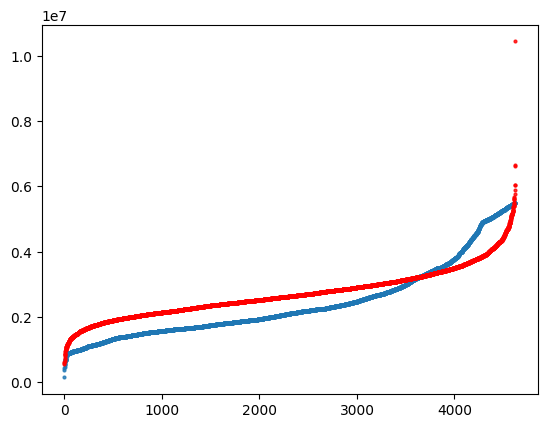

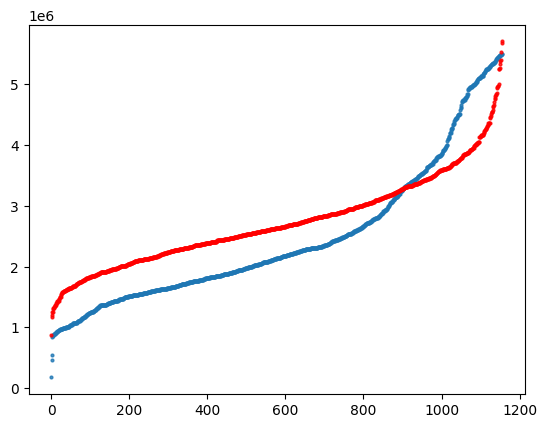

In [24]:
y_train_pred = model(x_train)[:, 0].tolist()
y_test_pred = model(x_test)[:, 0].tolist()

print("train error", regression_error(y_train.tolist(), y_train_pred))
print("test error", regression_error(y_test.tolist(), y_test_pred))

plt.plot(sorted(train_out), linestyle="", marker="o", markersize=2, alpha=0.8)
plt.plot(sorted(y_train_pred), linestyle="", marker="o", markersize=2, alpha=0.8, color="red")
plt.show()

plt.plot(sorted(test_out), linestyle="", marker="o", markersize=2, alpha=0.8)
plt.plot(sorted(y_test_pred), linestyle="", marker="o", markersize=2, alpha=0.8, color="red")
plt.show()

### Scale Output

Before we go much further with neural networks we should scale our outcome variables.

Due to the nature of the activation functions, it helps our network if all of our values are well-bounded and kept close to $0$.

In [ ]:
# TODO: Scale output feature

### Growing the Network

The error we were getting above was still around a million dollars. That's less than $1.0$ standard deviations... it's not bad, but it's also not good.

If we want to improve our model we can try adding layers to our Neural Network. We just have to make sure we add an activation function between the neurons. These are the functions that keep our model parameters within a nice, well-defined, range and, more importantly, allow the model to learn non-linear relationships between input and output features.

We're going to build the following network:

<img src="./imgs/linear_5x5x1.jpg" width="800px"/>

In [ ]:
model = nn.Sequential(
  nn.Linear(len(train_feat.columns), len(train_feat.columns)),
  nn.ReLU(),

  nn.Linear(len(train_feat.columns), 1),
)

optim = SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.MSELoss()

# display the number of parameters
print("number of parameters:", get_num_params(model))

# run on train data and check shape of output
y_pred = model(x_train)

x_train.shape, y_pred.shape

### A note about our optimizer

We're using one of the simpler optimizers in `PyTorch` to perform [_stochastic gradient descent_](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). Gradient descent is the official name of the algorithm that determines whether parameters have to increase or decrease, and by how much. _Stochastic_ means that it should still work if we sub-sample our input data and only use a subset of the data points at a time. It remembers/accumulates information about previous error measurements.

The documentation for the [`SGD` optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) has more info about the algorithm and the parameters it takes.

Other than simplifying our training code, these pre-built optimizers also perform dynamic learning rate adjustment and some other tricks that make our overall process not so sensitive to an exact learning rate.

The `PyTorch` library also has a number of [other optimizers](https://pytorch.org/docs/stable/optim.html#algorithms) useful for performing gradient descent. In addition to `SGD` we can also try [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) or [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html).

### Train it

We can train our new model, just like before, but since we have more parameters, it might take a bit longer to settle.

In [ ]:
# iterate 1000 times
for c in range(1000):
  # reset neuron annotations
  optim.zero_grad()
  # get predictions
  y_pred = model(x_train)[:, 0]
  # get iteration error
  loss = loss_fn(y_pred, y_train)
  # annotate neurons
  loss.backward()
  # update parameters
  optim.step()

  if c % 250 == 0:
    print(c, loss.item())

### Test dataset

We can still adjust a lot of parameters here, but before we spend too much time on this model, let's run it on the test dataset and calculate the average loss on data that wasn't used for training to see if the model is learning.

In [ ]:
y_train_pred = model(x_train)[:, 0].tolist()
y_test_pred = model(x_test)[:, 0].tolist()

print("train error", regression_error(y_train.tolist(), y_train_pred))
print("test error", regression_error(y_test.tolist(), y_test_pred))

plt.plot(sorted(train_out_std), linestyle="", marker="o", markersize=2, alpha=0.8)
plt.plot(sorted(y_train_pred), linestyle="", marker="o", markersize=2, alpha=0.8, color="red")
plt.show()

plt.plot(sorted(test_out_std), linestyle="", marker="o", markersize=2, alpha=0.8)
plt.plot(sorted(y_test_pred), linestyle="", marker="o", markersize=2, alpha=0.8, color="red")
plt.show()

### Interpretation

This isn't bad.

The absolute value of the error is kind of large, but the test dataset error is comparable to the training dataset error, which is a good indication that the model is not over-fitting.

Also, the plots show that the model is doing better at being able to achieve the price values in the dataset.

### Hyperparameters

We can spend some time adjusting the model, adding layers, changing the optimizer, the learning rate, experimenting with the optimizer's parameters, etc.

This process is usually referred to as _hyperparameter_ tuning, since we're picking parameters that will help us calculate the parameters of our neural network.

Here's a cell with all of the steps combined. We can play with the network architecture and parameters here.

In [ ]:
# Load Data
x_train = Tensor(train_feat.values)
y_train = Tensor(train_out_std.values)
x_test = Tensor(test_feat.values)
y_test = Tensor(test_out_std.values)


# TODO: adjust parameters, add layers
model = nn.Sequential(
  nn.Linear(len(train_feat.columns), len(train_feat.columns)),
  nn.ReLU(),

  nn.Linear(len(train_feat.columns), 1),
)

# print the number of parameters
print("number of parameters:", get_num_params(model))


# TODO: adjust parameters, add parameters, change optimizer
optim = SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.MSELoss()

# Train Model
for c in range(1024):
  optim.zero_grad()
  y_pred = model(x_train)[:, 0]
  loss = loss_fn(y_pred, y_train)
  loss.backward()
  optim.step()

  if c % 128 == 0:
    print(c, loss.item())

# Evaluate Model
y_train_pred = model(x_train)[:, 0].tolist()
y_test_pred = model(x_test)[:, 0].tolist()

print("train error", regression_error(y_train.tolist(), y_train_pred))
print("test error", regression_error(y_test.tolist(), y_test_pred))

### Interpretation

Our model is definitely learning, and seems like it's able to learn non-linear relationships like `PolynomialFeatures` automatically.